In [29]:
!pip3 install requests
!pip3 install tqdm
!pip3 install transformers
!pip3 install Pillow
!pip3 install torch
!pip3 install sentencepiece
!pip3 install torchvision
!pip3 install protobuf

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3

In [30]:
import requests
import uuid
import os
import json
from PIL import Image
from io import BytesIO

In [31]:
API_KEY = "9YdipTUx6AZWQ2sfWqGeEsdlhqLOwRWd"
ENDPOINT = "https://api.runware.ai/v1/image-inference"

In [32]:
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

In [33]:
DATASET_DIR = './input/circo-circo' # change here to "/kaggle/input/circo-circo" if you are running on Kaggle

In [34]:
def load_circo_dataset(dataset_path: str, split: str = 'test'):
    assert split in ['test', 'val'], "Split must be 'test' or 'val'"
    annotations_file = os.path.join(dataset_path, 'annotations', f'{split}.json')

    if not os.path.exists(annotations_file):
        raise FileNotFoundError(f"Annotation file not found: {annotations_file}")

    with open(annotations_file, 'r') as file:
        data = json.load(file)
    return data

In [35]:
def load_circo_image(dataset_path: str, img_id: str):    
    image_filename = f"{int(img_id):012}.jpg"
    image_path = os.path.join(dataset_path, 'COCO2017_unlabeled', 'unlabeled2017', image_filename)

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = Image.open(image_path)
    return image

In [46]:
def load_samples(dataset, indices: list, split: str = "test"):
    samples = [
        (
            dataset[index]['reference_img_id'],
            "Find " + dataset[index]['shared_concept'] + " but " + 
            dataset[index]['relative_caption'],
            dataset[index]['gt_img_ids'] if split == "val" else None,
        )
        for index in indices
    ]
    return samples

In [47]:
data = load_circo_dataset(dataset_path=DATASET_DIR, split='val')

In [48]:
samples = load_samples(data, indices=[i for i in range(len(data))], split="val")

In [49]:
samples[2]

(2097,
 'Find hairdressing comb and scissors but are being used by a person',
 [295260, 154188, 459306, 441068, 469312])

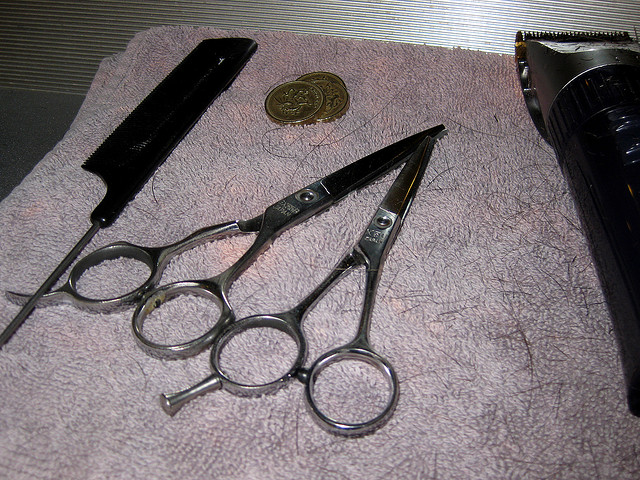

In [40]:
reference_image = load_circo_image(DATASET_DIR, 2097)
reference_image

In [41]:
# test 5 first samples
samples = samples[:5]

In [45]:
import base64

# Placeholder for the results
results = []

# Generate images using the API
for ref_img_id, caption, gt_img_ids in samples:
    try:
        # Load reference image
        reference_image = load_circo_image(DATASET_DIR, ref_img_id)
        
        # Convert reference image to base64 string
        buffered = BytesIO()
        reference_image.save(buffered, format="JPEG")
        seed_image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

        # Prepare API payload
        task_uuid = str(uuid.uuid4())
        payload = [
            {
                "taskType": "imageInference",
                "taskUUID": task_uuid,
                "positivePrompt": caption,
                "seedImage": seed_image_base64,
                "model": "runware:5@1",  # Replace with desired model ID
                "height": 512,
                "width": 512,
                "strength": 0.9,
                "outputType": "URL",
                "outputFormat": "PNG",
                "numberResults": 1
            }
        ]

        # Send the API request
        response = requests.post(ENDPOINT, headers=headers, json=payload)
        if response.status_code == 200:
            result = response.json()
            image_url = result["data"][0]["imageURL"]
            print(f"Generated image URL for ref_img_id {ref_img_id}: {image_url}")
            results.append({"id": ref_img_id, "url": image_url})
        else:
            print(f"Error {response.status_code}: {response.text}")
    except Exception as e:
        print(f"Error processing ref_img_id {ref_img_id}: {e}")


Generated image URL for ref_img_id 271520: https://im.runware.ai/image/ws/0.5/ii/943f86d9-5c46-4b35-a9a7-39f9d32c0fe5.png
Generated image URL for ref_img_id 283001: https://im.runware.ai/image/ws/0.5/ii/05019226-c3ad-4057-90dd-2cb5d9cd28a0.png
Generated image URL for ref_img_id 2097: https://im.runware.ai/image/ws/0.5/ii/d4d0d53b-d784-4d1e-895a-a98de79acd83.png
Generated image URL for ref_img_id 23082: https://im.runware.ai/image/ws/0.5/ii/183064e9-1ae4-4dd7-825b-cd65d4af0160.png
Generated image URL for ref_img_id 7705: https://im.runware.ai/image/ws/0.5/ii/a1536fee-1340-4e26-a383-8677c5a89310.png


In [14]:
# # Save results to a JSON file
output_file = "generated_images.json"
# with open(output_file, "w") as file:
#     json.dump(results, file, indent=4)

# print(f"Results saved to {output_file}")

In [15]:
# with open(output_file, "r") as file:
#     saved_results = json.load(file)

# print("Saved results:")
# print(json.dumps(saved_results, indent=4))

In [16]:
json_content = '''
[
    {
        "id": 271520,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d2510edb-b687-4844-9f57-d59a2066cd23.png"
    },
    {
        "id": 283001,
        "url": "https://im.runware.ai/image/ws/0.5/ii/104271e6-927e-49c2-944f-2946b87d1811.png"
    },
    {
        "id": 2097,
        "url": "https://im.runware.ai/image/ws/0.5/ii/886e9950-e017-4f01-b51d-c68d03ee9f89.png"
    },
    {
        "id": 23082,
        "url": "https://im.runware.ai/image/ws/0.5/ii/14421552-e506-4323-ae6f-25f9a6557a1e.png"
    },
    {
        "id": 7705,
        "url": "https://im.runware.ai/image/ws/0.5/ii/4e54e2e3-8a90-4ec9-9d6d-ccd1fa08b74e.png"
    },
    {
        "id": 391478,
        "url": "https://im.runware.ai/image/ws/0.5/ii/518f0f15-0fa1-4c89-8c58-87df770ae3e3.png"
    },
    {
        "id": 78739,
        "url": "https://im.runware.ai/image/ws/0.5/ii/28447831-105b-4add-8c01-6cf9b286d68e.png"
    },
    {
        "id": 530944,
        "url": "https://im.runware.ai/image/ws/0.5/ii/5889a045-3648-4b06-a76e-350470e0cbb3.png"
    },
    {
        "id": 475326,
        "url": "https://im.runware.ai/image/ws/0.5/ii/70fac28f-e235-47f2-a2cb-8ef50c5764e4.png"
    },
    {
        "id": 2407,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ca024081-387b-423e-a8c6-1190a64e5c16.png"
    },
    {
        "id": 414942,
        "url": "https://im.runware.ai/image/ws/0.5/ii/4e5b5fce-9827-440f-8213-a375853bc685.png"
    },
    {
        "id": 348264,
        "url": "https://im.runware.ai/image/ws/0.5/ii/71186d8f-866f-46aa-8550-f174f4005416.png"
    },
    {
        "id": 155151,
        "url": "https://im.runware.ai/image/ws/0.5/ii/924ebacd-6eff-489c-84f5-01a7520d2911.png"
    },
    {
        "id": 85932,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c63d0f2d-4fd4-43bc-9693-412392c6e864.png"
    },
    {
        "id": 160161,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7afb22e6-c2ea-4d90-84f9-3e6186e71f2f.png"
    },
    {
        "id": 197996,
        "url": "https://im.runware.ai/image/ws/0.5/ii/0c11bf9f-0372-4618-8010-3836c521fb38.png"
    },
    {
        "id": 233673,
        "url": "https://im.runware.ai/image/ws/0.5/ii/11d84a6e-f0d2-4534-ab92-52443e51a8bb.png"
    },
    {
        "id": 136863,
        "url": "https://im.runware.ai/image/ws/0.5/ii/dc2ba366-572e-4f17-8d04-bb07b845da43.png"
    },
    {
        "id": 358023,
        "url": "https://im.runware.ai/image/ws/0.5/ii/f20f2393-19e9-4c64-bfa7-5777d141c7b8.png"
    },
    {
        "id": 69473,
        "url": "https://im.runware.ai/image/ws/0.5/ii/6f89e1c9-52c9-46a0-8050-3011ee33e834.png"
    },
    {
        "id": 251150,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7e9aceaf-af41-49c0-abe3-5ecd4b131227.png"
    },
    {
        "id": 198618,
        "url": "https://im.runware.ai/image/ws/0.5/ii/39e87f41-417e-4802-a4e4-ecdc80784963.png"
    },
    {
        "id": 106135,
        "url": "https://im.runware.ai/image/ws/0.5/ii/94c3ede6-a0e0-4e9d-a9d2-57f633e33123.png"
    },
    {
        "id": 154818,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ea5bdce1-5fe2-4bfc-abd6-2e0369355e81.png"
    },
    {
        "id": 227965,
        "url": "https://im.runware.ai/image/ws/0.5/ii/70639cbb-278a-48da-ae2a-ed8aa28e192a.png"
    },
    {
        "id": 40167,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c14e908d-9d6d-482d-b7e5-8c8fbe7d5c4c.png"
    },
    {
        "id": 43964,
        "url": "https://im.runware.ai/image/ws/0.5/ii/449d6370-88d7-427d-be8d-212feba27c5c.png"
    },
    {
        "id": 54657,
        "url": "https://im.runware.ai/image/ws/0.5/ii/8af7b507-e5da-487f-a821-ab1a641ccb07.png"
    },
    {
        "id": 493700,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a6476d50-1a57-4afb-bf3f-1f9cb7fcd32f.png"
    },
    {
        "id": 209213,
        "url": "https://im.runware.ai/image/ws/0.5/ii/0ae31003-62de-44ae-ac80-9d515c9904d8.png"
    },
    {
        "id": 368504,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d9be7995-74b3-4658-802c-b17be591e94d.png"
    },
    {
        "id": 179912,
        "url": "https://im.runware.ai/image/ws/0.5/ii/42c337b8-3e33-43e8-8c39-16e7b40309c3.png"
    },
    {
        "id": 258810,
        "url": "https://im.runware.ai/image/ws/0.5/ii/52493381-c96b-4a50-a697-af50096d6e08.png"
    },
    {
        "id": 413040,
        "url": "https://im.runware.ai/image/ws/0.5/ii/1e30cbca-870e-4993-9024-124276cd4b55.png"
    },
    {
        "id": 464273,
        "url": "https://im.runware.ai/image/ws/0.5/ii/14b29ced-f65e-4e27-9ff5-c6ec860ee397.png"
    },
    {
        "id": 108705,
        "url": "https://im.runware.ai/image/ws/0.5/ii/f9ecb168-7a10-4a7f-871a-3d3823baf218.png"
    },
    {
        "id": 451484,
        "url": "https://im.runware.ai/image/ws/0.5/ii/e80d3a4c-596c-4710-bf13-05f87c9794da.png"
    },
    {
        "id": 536897,
        "url": "https://im.runware.ai/image/ws/0.5/ii/fc375fac-e3be-4edf-9200-7ff7156967c1.png"
    },
    {
        "id": 518271,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ea07ffa9-ff2e-4451-8735-04ded47d966a.png"
    },
    {
        "id": 114623,
        "url": "https://im.runware.ai/image/ws/0.5/ii/28d20451-6caf-44c3-a02f-76e651c275fa.png"
    },
    {
        "id": 381893,
        "url": "https://im.runware.ai/image/ws/0.5/ii/f9609a92-4e09-408d-b23e-921235170cea.png"
    },
    {
        "id": 345478,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c62b3cc6-a39b-4485-9242-220716a53026.png"
    },
    {
        "id": 401686,
        "url": "https://im.runware.ai/image/ws/0.5/ii/cde4956f-9529-436b-88fd-8c233bd7e024.png"
    },
    {
        "id": 300555,
        "url": "https://im.runware.ai/image/ws/0.5/ii/007adeb9-e2ed-430b-b03c-b4279a643660.png"
    },
    {
        "id": 538294,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d509c734-e18b-4e1f-9d64-9147d5333b38.png"
    },
    {
        "id": 65291,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d4e4e928-31ac-44de-b2d5-bd8c93936835.png"
    },
    {
        "id": 190235,
        "url": "https://im.runware.ai/image/ws/0.5/ii/fb08b24a-1ee3-48c9-bb4a-26411bc19466.png"
    },
    {
        "id": 217569,
        "url": "https://im.runware.ai/image/ws/0.5/ii/199639e4-6975-4c20-b6bc-216bbac8321a.png"
    },
    {
        "id": 211233,
        "url": "https://im.runware.ai/image/ws/0.5/ii/5189d268-ea81-462c-abf9-25b57af2e9f1.png"
    },
    {
        "id": 188326,
        "url": "https://im.runware.ai/image/ws/0.5/ii/e9d22c57-9f32-43c5-b5af-318e19b6933b.png"
    },
    {
        "id": 412387,
        "url": "https://im.runware.ai/image/ws/0.5/ii/3bcac132-cf40-4262-bac5-7e499d788e28.png"
    },
    {
        "id": 185057,
        "url": "https://im.runware.ai/image/ws/0.5/ii/9396b7c3-480f-4dd5-932e-b4ca64151fb5.png"
    },
    {
        "id": 446857,
        "url": "https://im.runware.ai/image/ws/0.5/ii/55b48ab8-937c-4347-b2ca-b41d59e92068.png"
    },
    {
        "id": 221825,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a60b6a48-a510-4a71-9761-ba860cdd71a9.png"
    },
    {
        "id": 344752,
        "url": "https://im.runware.ai/image/ws/0.5/ii/3589c9d5-41fd-4dc2-9efa-59c892069475.png"
    },
    {
        "id": 453004,
        "url": "https://im.runware.ai/image/ws/0.5/ii/e95a42bd-5082-4eaf-a945-2bb855248208.png"
    },
    {
        "id": 353913,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7bf25545-4001-4a80-a9e0-46cbbb3dcb57.png"
    },
    {
        "id": 137736,
        "url": "https://im.runware.ai/image/ws/0.5/ii/646a0613-7513-4ba6-858e-0d68578826b8.png"
    },
    {
        "id": 536548,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7e4a089f-449d-4989-beb2-c4e215175950.png"
    },
    {
        "id": 534261,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c55bb341-74c4-4eca-a470-97b340c50143.png"
    },
    {
        "id": 283297,
        "url": "https://im.runware.ai/image/ws/0.5/ii/4df75447-5f14-43ff-b99e-272482498723.png"
    },
    {
        "id": 543250,
        "url": "https://im.runware.ai/image/ws/0.5/ii/70c29596-72bb-4fe5-b910-331259f4e1b9.png"
    },
    {
        "id": 96447,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7a854cc3-3b23-4f50-a55f-a26b8419241e.png"
    },
    {
        "id": 191099,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a023986f-f0ce-442c-a3af-781eae012142.png"
    },
    {
        "id": 103052,
        "url": "https://im.runware.ai/image/ws/0.5/ii/6f52fa07-c574-432f-85d6-6ad20e91dcf3.png"
    },
    {
        "id": 485893,
        "url": "https://im.runware.ai/image/ws/0.5/ii/b9c8bd55-6694-4353-8d50-56db266ab99b.png"
    },
    {
        "id": 274752,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d13f184a-b41f-4278-9eed-ea828cbeb4bc.png"
    },
    {
        "id": 460958,
        "url": "https://im.runware.ai/image/ws/0.5/ii/af6a1911-00e5-4153-a320-749a8e185de6.png"
    },
    {
        "id": 71315,
        "url": "https://im.runware.ai/image/ws/0.5/ii/fe42fb02-b88e-4a55-980c-5f39a13553ab.png"
    },
    {
        "id": 467759,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a4e663e0-88f1-4c66-a819-3d8a523343f7.png"
    },
    {
        "id": 236888,
        "url": "https://im.runware.ai/image/ws/0.5/ii/cf2715dc-c992-4228-8d5b-8f36f7e93da1.png"
    },
    {
        "id": 290176,
        "url": "https://im.runware.ai/image/ws/0.5/ii/6f80a04e-599d-4d50-888a-95b27c991c50.png"
    },
    {
        "id": 305928,
        "url": "https://im.runware.ai/image/ws/0.5/ii/149a0a9b-fcfe-4202-ac0d-6730cd6aca35.png"
    },
    {
        "id": 78304,
        "url": "https://im.runware.ai/image/ws/0.5/ii/2e723890-97cb-4f3f-9ed4-64c6844628af.png"
    },
    {
        "id": 196466,
        "url": "https://im.runware.ai/image/ws/0.5/ii/455a2184-1fbf-4b57-9814-d9a644df6107.png"
    },
    {
        "id": 277153,
        "url": "https://im.runware.ai/image/ws/0.5/ii/e9ab3f5c-a108-4b7f-bbd1-4a62bec0c41f.png"
    },
    {
        "id": 312363,
        "url": "https://im.runware.ai/image/ws/0.5/ii/0dccd04c-1665-434b-ba02-5bf9777a676d.png"
    },
    {
        "id": 70738,
        "url": "https://im.runware.ai/image/ws/0.5/ii/8ae15722-6a78-406e-a063-1cac3bb3532d.png"
    },
    {
        "id": 516117,
        "url": "https://im.runware.ai/image/ws/0.5/ii/bb9d695d-e2e7-43de-b07c-284c0819b318.png"
    },
    {
        "id": 289106,
        "url": "https://im.runware.ai/image/ws/0.5/ii/fb31e6c3-e61e-486d-9678-a118bfcce49f.png"
    },
    {
        "id": 30285,
        "url": "https://im.runware.ai/image/ws/0.5/ii/e6c93f8b-ea2e-4025-8f40-b8651d7914ce.png"
    },
    {
        "id": 67448,
        "url": "https://im.runware.ai/image/ws/0.5/ii/03ec0d9e-1cdc-4534-96d4-99e536d4d3ba.png"
    },
    {
        "id": 48838,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d2bcb041-6d92-4b84-9ac7-8f1a2de25af4.png"
    },
    {
        "id": 317955,
        "url": "https://im.runware.ai/image/ws/0.5/ii/f82b7597-cc6e-44f9-9bbb-6080e6e0714a.png"
    },
    {
        "id": 2010,
        "url": "https://im.runware.ai/image/ws/0.5/ii/09da84d1-21d6-428f-ae12-5edbf9fc9860.png"
    },
    {
        "id": 496721,
        "url": "https://im.runware.ai/image/ws/0.5/ii/fbcfe0f3-0833-4542-9ff5-3e6b29f1ba76.png"
    },
    {
        "id": 560234,
        "url": "https://im.runware.ai/image/ws/0.5/ii/db7e388c-06dd-4cc1-a8df-610284673395.png"
    },
    {
        "id": 194689,
        "url": "https://im.runware.ai/image/ws/0.5/ii/36a8aa2e-208b-4763-9379-a2e4cdf5d6d0.png"
    },
    {
        "id": 347305,
        "url": "https://im.runware.ai/image/ws/0.5/ii/8fa4cb89-b5e6-480f-8b73-513c2539016c.png"
    },
    {
        "id": 319241,
        "url": "https://im.runware.ai/image/ws/0.5/ii/063b10ac-5f29-4fd3-8698-c57138f66020.png"
    },
    {
        "id": 192149,
        "url": "https://im.runware.ai/image/ws/0.5/ii/f950d6c6-45c9-451b-8195-57c6ecaa6387.png"
    },
    {
        "id": 213941,
        "url": "https://im.runware.ai/image/ws/0.5/ii/18f984ca-ced8-4a21-969c-2332a95dda16.png"
    },
    {
        "id": 100654,
        "url": "https://im.runware.ai/image/ws/0.5/ii/dc2082fc-38df-4c83-94b7-4b8f47fedc2e.png"
    },
    {
        "id": 434490,
        "url": "https://im.runware.ai/image/ws/0.5/ii/9d2dc178-9b8d-4e83-9295-9ffe2a4e6b71.png"
    },
    {
        "id": 369366,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a87ad285-6de0-49a0-b4ce-fa1127280def.png"
    },
    {
        "id": 213544,
        "url": "https://im.runware.ai/image/ws/0.5/ii/291eeb20-ff11-428c-bf82-0a5343a04488.png"
    },
    {
        "id": 374475,
        "url": "https://im.runware.ai/image/ws/0.5/ii/af985988-3911-435b-bc4c-098d01773384.png"
    },
    {
        "id": 139274,
        "url": "https://im.runware.ai/image/ws/0.5/ii/5e1673ea-69e7-430b-8e22-703ccc0c9ad6.png"
    },
    {
        "id": 297331,
        "url": "https://im.runware.ai/image/ws/0.5/ii/2c8161f7-c35f-4142-8aed-2603d606d265.png"
    },
    {
        "id": 309794,
        "url": "https://im.runware.ai/image/ws/0.5/ii/6fbd5588-8692-49f2-811f-74adafef8d10.png"
    },
    {
        "id": 126421,
        "url": "https://im.runware.ai/image/ws/0.5/ii/50d20a32-dee5-470c-93ed-9745bd8d343e.png"
    },
    {
        "id": 420870,
        "url": "https://im.runware.ai/image/ws/0.5/ii/2f41f742-e924-467b-95bc-93d66ff63c08.png"
    },
    {
        "id": 277771,
        "url": "https://im.runware.ai/image/ws/0.5/ii/e43b60e9-611b-427e-8991-03038d9f4267.png"
    },
    {
        "id": 67787,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ac7f83f9-9859-489b-9333-4c201c3a05d9.png"
    },
    {
        "id": 550823,
        "url": "https://im.runware.ai/image/ws/0.5/ii/fe4a3de2-59ca-4a5f-b8ac-d50f39d1d1e8.png"
    },
    {
        "id": 104530,
        "url": "https://im.runware.ai/image/ws/0.5/ii/aca4936f-123b-4255-b4c7-7612854c791c.png"
    },
    {
        "id": 63597,
        "url": "https://im.runware.ai/image/ws/0.5/ii/b62a283f-e8bc-49b5-82cc-50e4b2f9e10b.png"
    },
    {
        "id": 493122,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7e5b252d-9881-44af-924b-bd0ec88f9ec0.png"
    },
    {
        "id": 160210,
        "url": "https://im.runware.ai/image/ws/0.5/ii/9dec05c1-d773-4884-b2ac-de4220eaf1e3.png"
    },
    {
        "id": 127334,
        "url": "https://im.runware.ai/image/ws/0.5/ii/51cfb3c6-e03a-41f9-85c1-2406653c4433.png"
    },
    {
        "id": 110295,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a06b0e6c-fd00-4ebd-ac78-96a328a1cdbf.png"
    },
    {
        "id": 395270,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d10b03e0-9f8b-47e0-b383-106acea45cdd.png"
    },
    {
        "id": 2192,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ee605e7b-fdc7-4428-b82f-e4880c3498d1.png"
    },
    {
        "id": 381726,
        "url": "https://im.runware.ai/image/ws/0.5/ii/b871b839-639e-4924-b4b9-e4a41b32e8bf.png"
    },
    {
        "id": 6784,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c32b95bd-b2e5-431e-9f03-debe8ebe273f.png"
    },
    {
        "id": 540829,
        "url": "https://im.runware.ai/image/ws/0.5/ii/bfc2bc2c-4948-4a96-855a-b2d0e2b4db6c.png"
    },
    {
        "id": 157484,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ce693f2b-09ff-4676-a9e9-2a3c0ffcafff.png"
    },
    {
        "id": 272126,
        "url": "https://im.runware.ai/image/ws/0.5/ii/9ac7b7ba-0287-4b9a-b430-fd70c12233db.png"
    },
    {
        "id": 151606,
        "url": "https://im.runware.ai/image/ws/0.5/ii/02a66591-1906-4d75-81ee-83d0ecbf50bc.png"
    },
    {
        "id": 526302,
        "url": "https://im.runware.ai/image/ws/0.5/ii/cbcdb6b8-003d-48e5-9027-b845f3dd61f8.png"
    },
    {
        "id": 520651,
        "url": "https://im.runware.ai/image/ws/0.5/ii/207fdcce-79f5-4f96-8662-cebc4cb21b6d.png"
    },
    {
        "id": 95581,
        "url": "https://im.runware.ai/image/ws/0.5/ii/6b7ee48f-6493-4bd1-bb40-e9d2e9691778.png"
    },
    {
        "id": 471110,
        "url": "https://im.runware.ai/image/ws/0.5/ii/0bf37d66-1929-469c-9298-19265ba54cd8.png"
    },
    {
        "id": 69885,
        "url": "https://im.runware.ai/image/ws/0.5/ii/e35d8ba7-35ed-4623-af7f-e08c5b7d6e6f.png"
    },
    {
        "id": 249917,
        "url": "https://im.runware.ai/image/ws/0.5/ii/47e9b4be-740c-4f32-9f00-78b88ee03d1b.png"
    },
    {
        "id": 428606,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c16e673a-2e0b-4c1c-b6fe-98c7e0840673.png"
    },
    {
        "id": 98850,
        "url": "https://im.runware.ai/image/ws/0.5/ii/0b1e95ee-cb86-45e0-a475-c0ec044e61c2.png"
    },
    {
        "id": 223654,
        "url": "https://im.runware.ai/image/ws/0.5/ii/852bb81c-4394-4c20-a041-bd932e735d26.png"
    },
    {
        "id": 100047,
        "url": "https://im.runware.ai/image/ws/0.5/ii/85541d7a-83e9-41a7-acbb-de91410594ac.png"
    },
    {
        "id": 405343,
        "url": "https://im.runware.ai/image/ws/0.5/ii/f28a399e-50dd-44ed-a5c1-16c4b6c893fb.png"
    },
    {
        "id": 305456,
        "url": "https://im.runware.ai/image/ws/0.5/ii/9292a7b7-4380-455b-8fac-a6f40e0e20cc.png"
    },
    {
        "id": 157557,
        "url": "https://im.runware.ai/image/ws/0.5/ii/78bfa67a-d590-45de-bc1e-201d10f3abda.png"
    },
    {
        "id": 212845,
        "url": "https://im.runware.ai/image/ws/0.5/ii/691223a9-28bc-46cd-9b04-6a3ea1da0160.png"
    },
    {
        "id": 81483,
        "url": "https://im.runware.ai/image/ws/0.5/ii/bd8e099f-ac8e-48e6-9c43-00a0be4ed069.png"
    },
    {
        "id": 280105,
        "url": "https://im.runware.ai/image/ws/0.5/ii/31325771-6374-4b13-9396-91c627aee2bc.png"
    },
    {
        "id": 367756,
        "url": "https://im.runware.ai/image/ws/0.5/ii/87ee974d-323e-4cec-b8b9-d003df70f21f.png"
    },
    {
        "id": 46780,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a6e14c7e-14a1-40bb-918a-24fbe50303a0.png"
    },
    {
        "id": 211621,
        "url": "https://im.runware.ai/image/ws/0.5/ii/60200ba4-533d-4d76-881a-2943b3c7b862.png"
    },
    {
        "id": 15169,
        "url": "https://im.runware.ai/image/ws/0.5/ii/95ea7e62-0258-416e-befc-6319df255abd.png"
    },
    {
        "id": 248852,
        "url": "https://im.runware.ai/image/ws/0.5/ii/700fb782-1778-48d8-a8a6-8c8554e329bd.png"
    },
    {
        "id": 253571,
        "url": "https://im.runware.ai/image/ws/0.5/ii/bc53d124-ab78-42bc-80d2-402a863d1b1f.png"
    },
    {
        "id": 443402,
        "url": "https://im.runware.ai/image/ws/0.5/ii/2c8a5ee8-77b3-4bbe-92b9-52700d621961.png"
    },
    {
        "id": 91521,
        "url": "https://im.runware.ai/image/ws/0.5/ii/5dae0490-0f9f-4493-8afa-2f1fafa18117.png"
    },
    {
        "id": 558856,
        "url": "https://im.runware.ai/image/ws/0.5/ii/140edb12-93b4-4aef-9597-03429d3e0d79.png"
    },
    {
        "id": 50577,
        "url": "https://im.runware.ai/image/ws/0.5/ii/2fb6c839-c6a3-4d83-a686-4fce1d6c5100.png"
    },
    {
        "id": 168688,
        "url": "https://im.runware.ai/image/ws/0.5/ii/599265a1-a193-481c-8fdf-25f6c826431f.png"
    },
    {
        "id": 189891,
        "url": "https://im.runware.ai/image/ws/0.5/ii/44a34cd7-e3c8-412e-a321-3601d78d81d0.png"
    },
    {
        "id": 101395,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a5eeae16-162b-4051-be28-cb61a6c29d91.png"
    },
    {
        "id": 548329,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d41e45bd-04bf-48ef-b825-9a955899d4f6.png"
    },
    {
        "id": 358487,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ffe80b9f-4da4-4f22-bca3-b948ed2b89db.png"
    },
    {
        "id": 377267,
        "url": "https://im.runware.ai/image/ws/0.5/ii/9f7d4d4c-e4e1-4f83-831a-a9f7a1f884a2.png"
    },
    {
        "id": 284361,
        "url": "https://im.runware.ai/image/ws/0.5/ii/aa2eb63f-f20b-44d2-a1eb-2ce7849a9e31.png"
    },
    {
        "id": 558897,
        "url": "https://im.runware.ai/image/ws/0.5/ii/0a1fe609-6a4f-4766-b64a-bacb9ff3f903.png"
    },
    {
        "id": 238995,
        "url": "https://im.runware.ai/image/ws/0.5/ii/3e0e9e24-8d46-4c14-a347-593419a7703f.png"
    },
    {
        "id": 494347,
        "url": "https://im.runware.ai/image/ws/0.5/ii/bd65c321-50b4-4762-bfca-b622064e3524.png"
    },
    {
        "id": 416518,
        "url": "https://im.runware.ai/image/ws/0.5/ii/6a17fb93-4ea5-42fa-a1a7-61d14b44e086.png"
    },
    {
        "id": 447096,
        "url": "https://im.runware.ai/image/ws/0.5/ii/130ba38d-3d64-4ae5-9cfe-16bf83170514.png"
    },
    {
        "id": 389808,
        "url": "https://im.runware.ai/image/ws/0.5/ii/62f2831b-89ed-4daa-a986-588c135c776c.png"
    },
    {
        "id": 484774,
        "url": "https://im.runware.ai/image/ws/0.5/ii/5639c311-9bbb-419f-8c32-948c87318af5.png"
    },
    {
        "id": 112439,
        "url": "https://im.runware.ai/image/ws/0.5/ii/32247a12-9f00-4d4e-addb-e1a542ce0ba4.png"
    },
    {
        "id": 477859,
        "url": "https://im.runware.ai/image/ws/0.5/ii/91c9931e-df1b-4303-bfbb-438ccecfda97.png"
    },
    {
        "id": 179795,
        "url": "https://im.runware.ai/image/ws/0.5/ii/940fbf16-ae17-4ba6-bf2a-bd2c2eb3e25a.png"
    },
    {
        "id": 392547,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a0eceb49-4c32-42c5-b0a7-8fc28259c861.png"
    },
    {
        "id": 192695,
        "url": "https://im.runware.ai/image/ws/0.5/ii/24df963e-2c01-4409-9b11-4f761f3a1059.png"
    },
    {
        "id": 320665,
        "url": "https://im.runware.ai/image/ws/0.5/ii/5c4a331a-b97b-4f2e-be40-3644c8ce1531.png"
    },
    {
        "id": 515554,
        "url": "https://im.runware.ai/image/ws/0.5/ii/b589c7a5-44e7-4a1a-a0b9-fb892603aad8.png"
    },
    {
        "id": 458004,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a6bac3b8-9fc3-4458-a9e9-d40f3419e710.png"
    },
    {
        "id": 169093,
        "url": "https://im.runware.ai/image/ws/0.5/ii/645a735c-b78a-4d21-9c78-89701c2a2678.png"
    },
    {
        "id": 548497,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ba2b2bed-08ac-40aa-ab65-48d21c517883.png"
    },
    {
        "id": 221372,
        "url": "https://im.runware.ai/image/ws/0.5/ii/5bbda49b-3d72-4f2b-aeb9-ed350664eb65.png"
    },
    {
        "id": 131180,
        "url": "https://im.runware.ai/image/ws/0.5/ii/57ea0ccb-0839-455e-9948-1af215312cd0.png"
    },
    {
        "id": 179387,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7dcb0d67-4cbc-4b11-a5d9-d3d98c4f0d2c.png"
    },
    {
        "id": 68679,
        "url": "https://im.runware.ai/image/ws/0.5/ii/286c12c5-10ea-4038-b2f7-9f9449d52695.png"
    },
    {
        "id": 20233,
        "url": "https://im.runware.ai/image/ws/0.5/ii/9c68e9ff-12bb-4072-b187-d1553878197c.png"
    },
    {
        "id": 270915,
        "url": "https://im.runware.ai/image/ws/0.5/ii/91371a13-e89c-4dbc-8ca8-5f23ad062ad9.png"
    },
    {
        "id": 231711,
        "url": "https://im.runware.ai/image/ws/0.5/ii/93115384-386f-47d9-a941-3df179060f08.png"
    },
    {
        "id": 521425,
        "url": "https://im.runware.ai/image/ws/0.5/ii/f21587ea-91ec-4fe5-af67-b0947e8fd507.png"
    },
    {
        "id": 358397,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c80fdd32-0a12-402b-919b-417590440563.png"
    },
    {
        "id": 42157,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d3a29537-ef42-4ca3-b603-2a04aec126c8.png"
    },
    {
        "id": 573423,
        "url": "https://im.runware.ai/image/ws/0.5/ii/84aee94f-9d5f-4ffe-b3fa-606260737fa2.png"
    },
    {
        "id": 197747,
        "url": "https://im.runware.ai/image/ws/0.5/ii/96423b69-4f94-442c-b37a-9e18dbd73db2.png"
    },
    {
        "id": 386048,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c517cf87-38c7-477d-abb5-e7aa94fafad2.png"
    },
    {
        "id": 282616,
        "url": "https://im.runware.ai/image/ws/0.5/ii/73b69ccf-aa32-452f-8933-958ffb001d2c.png"
    },
    {
        "id": 174566,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d4630b3e-a0da-4a1b-a301-cbfe5b9780a8.png"
    },
    {
        "id": 288479,
        "url": "https://im.runware.ai/image/ws/0.5/ii/35591568-93ab-437a-9714-b36b2bcef95e.png"
    },
    {
        "id": 377035,
        "url": "https://im.runware.ai/image/ws/0.5/ii/5f1abf57-e3fb-4ce0-b58f-b970a8c6ee17.png"
    },
    {
        "id": 409923,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c7e0dbe8-a73c-43bc-a19e-cd4d005a3385.png"
    },
    {
        "id": 440165,
        "url": "https://im.runware.ai/image/ws/0.5/ii/10bd0753-cc96-4859-8cb1-c9a82b284b1a.png"
    },
    {
        "id": 398192,
        "url": "https://im.runware.ai/image/ws/0.5/ii/de10eeed-e609-4f02-bef1-0d64efb76ce5.png"
    },
    {
        "id": 550727,
        "url": "https://im.runware.ai/image/ws/0.5/ii/b683f49e-3ff2-4405-a0e0-9cd67ad0e80f.png"
    },
    {
        "id": 554930,
        "url": "https://im.runware.ai/image/ws/0.5/ii/111cbe09-46b1-41be-9efb-9501547209bf.png"
    },
    {
        "id": 311008,
        "url": "https://im.runware.ai/image/ws/0.5/ii/8fcc5f95-0ad7-40d8-80d8-1a120ab0dd5d.png"
    },
    {
        "id": 418908,
        "url": "https://im.runware.ai/image/ws/0.5/ii/992f3014-8afa-4e4b-8411-a52abb31c6c7.png"
    },
    {
        "id": 299069,
        "url": "https://im.runware.ai/image/ws/0.5/ii/2d22b0e8-0424-402d-a4b6-9536598c6fff.png"
    },
    {
        "id": 460011,
        "url": "https://im.runware.ai/image/ws/0.5/ii/69da5a0d-3d5b-43cf-8383-7265b83ead31.png"
    },
    {
        "id": 271990,
        "url": "https://im.runware.ai/image/ws/0.5/ii/aa68a1a3-5887-4a74-aec9-64af0566ae5e.png"
    },
    {
        "id": 113930,
        "url": "https://im.runware.ai/image/ws/0.5/ii/6b8ba7b7-31af-43e6-9de5-96b05d71c250.png"
    },
    {
        "id": 347341,
        "url": "https://im.runware.ai/image/ws/0.5/ii/63aaef54-c0ca-456f-bae3-b3e54249ac4d.png"
    },
    {
        "id": 69639,
        "url": "https://im.runware.ai/image/ws/0.5/ii/68bb04c5-ae55-4afd-a659-05f01de33a45.png"
    },
    {
        "id": 94215,
        "url": "https://im.runware.ai/image/ws/0.5/ii/77f70d00-867a-4350-a966-190b27f14752.png"
    },
    {
        "id": 107478,
        "url": "https://im.runware.ai/image/ws/0.5/ii/d408c898-727b-4d4e-aa29-909cf4696ec7.png"
    },
    {
        "id": 364450,
        "url": "https://im.runware.ai/image/ws/0.5/ii/0b3858e1-9c69-4c5b-a94d-8baa68ac5044.png"
    },
    {
        "id": 97310,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7c65c876-8f8b-422f-819d-7971eade8ac9.png"
    },
    {
        "id": 19433,
        "url": "https://im.runware.ai/image/ws/0.5/ii/ecfcdc0a-ca4c-4471-8870-5cd7e2327b24.png"
    },
    {
        "id": 549959,
        "url": "https://im.runware.ai/image/ws/0.5/ii/98a7fa07-3a39-44f0-be8a-fece57d947c7.png"
    },
    {
        "id": 247405,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c756f864-9126-4c45-b271-422aeeb37cd5.png"
    },
    {
        "id": 190244,
        "url": "https://im.runware.ai/image/ws/0.5/ii/1040ba5e-0c52-46f0-9cfd-ca4fc2f155b9.png"
    },
    {
        "id": 416863,
        "url": "https://im.runware.ai/image/ws/0.5/ii/c26a2f02-e1b5-4814-b399-b344d36cd3dd.png"
    },
    {
        "id": 485488,
        "url": "https://im.runware.ai/image/ws/0.5/ii/b47b5b04-cab9-489a-a47d-89e72f064ab9.png"
    },
    {
        "id": 12234,
        "url": "https://im.runware.ai/image/ws/0.5/ii/1429b2cc-ac28-4b49-9f6b-a17b72ee9320.png"
    },
    {
        "id": 15820,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a92d712b-b001-4690-9013-f359e5a1d321.png"
    },
    {
        "id": 467550,
        "url": "https://im.runware.ai/image/ws/0.5/ii/16f28628-4082-410d-ade4-8602687bb99e.png"
    },
    {
        "id": 223446,
        "url": "https://im.runware.ai/image/ws/0.5/ii/69119244-7e94-48d6-8819-dba7ab25a5c5.png"
    },
    {
        "id": 278678,
        "url": "https://im.runware.ai/image/ws/0.5/ii/7607ac8a-3b9f-491a-af0a-5fe0f66a1714.png"
    },
    {
        "id": 119289,
        "url": "https://im.runware.ai/image/ws/0.5/ii/30dd02fa-5c69-4fff-8ac5-e4406efe9f8e.png"
    },
    {
        "id": 515239,
        "url": "https://im.runware.ai/image/ws/0.5/ii/9f44f0bc-3c2a-4704-8208-cc336986962e.png"
    },
    {
        "id": 245509,
        "url": "https://im.runware.ai/image/ws/0.5/ii/67537c9e-dede-4541-91d9-8bce28360f30.png"
    },
    {
        "id": 372035,
        "url": "https://im.runware.ai/image/ws/0.5/ii/30b3cdb5-7a25-4d65-b13c-4b1949b9a718.png"
    },
    {
        "id": 80702,
        "url": "https://im.runware.ai/image/ws/0.5/ii/810f2d7e-0f60-4515-bca1-46489a245b58.png"
    },
    {
        "id": 445907,
        "url": "https://im.runware.ai/image/ws/0.5/ii/a94491bc-8342-48c2-8289-ae4ac3bd2040.png"
    }
]
'''

In [17]:
with open(output_file, "w") as file:
    file.write(json_content)

# Calc feature

In [18]:
# !pip install transformers

In [19]:
import json
import requests
from PIL import Image
from transformers import AutoProcessor, AutoModel
import torch
import os
import numpy as np

/Users/anhvietnguyen/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
model_name = "google/siglip-base-patch16-224"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [21]:
output_file = "generated_images.json"
with open(output_file, "r") as file:
    generated_images = json.load(file)

In [22]:
output_dir = "generated_imgs"

In [23]:
import os
import requests
from typing import List, Dict

def download_images_from_json(json_file: str, output_dir: str) -> List[Dict[str, str]]:
    """
    Download images specified in a JSON file containing 'id' and 'url'.
    
    Args:
        json_file (str): Path to the JSON file containing image metadata.
        output_dir (str): Directory to save downloaded images.
    
    Returns:
        List[Dict[str, str]]: A list of dictionaries with 'id', 'url', and 'status' for each image.
                              'status' indicates 'success' or 'failed' for each download.
    """
    # Load JSON data
    with open(json_file, "r") as file:
        image_data = json.load(file)
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Placeholder for download results
    download_results = []
    
    # Process each image
    for item in image_data:
        image_id = item.get("id")
        image_url = item.get("url")
        if not image_id or not image_url:
            print(f"Skipping invalid entry: {item}")
            continue
        
        # Define the output image path
        image_path = os.path.join(output_dir, f"{image_id}.jpg")
        
        try:
            # Download the image
            response = requests.get(image_url, stream=True)
            if response.status_code == 200:
                with open(image_path, "wb") as img_file:
                    img_file.write(response.content)
                print(f"Downloaded image {image_id} successfully.")
                download_results.append({"id": image_id, "url": image_url, "status": "success"})
            else:
                print(f"Failed to download image {image_id}: HTTP {response.status_code}")
                download_results.append({"id": image_id, "url": image_url, "status": "failed"})
        except Exception as e:
            print(f"Error downloading image {image_id}: {e}")
            download_results.append({"id": image_id, "url": image_url, "status": "failed"})
    
    return download_results

In [24]:
with open(output_file, "w") as file:
    file.write(json_content)

print(f"JSON content written to {output_file} successfully.")

JSON content written to generated_images.json successfully.


In [25]:
# download_images_from_json(output_file, output_dir) # uncomment to download images

## Indexing

In [26]:
from PIL import Image
import requests
from transformers import AutoProcessor, SiglipVisionModel

model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled features

KeyboardInterrupt: 

In [ ]:
pooled_output[0].shape

torch.Size([768])

In [ ]:
!pip3 install pinecone

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="pcsk_3RudCY_4tz2o8yhcjCBgmweWseUzco5ehdEkZPytepadYngEpY4U1ePqKiCRY7NDGjwSKo")
index_name = "circo1"
pc.create_index(
    name=index_name,
    dimension=768, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

PineconeApiException: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2024-07', 'X-Cloud-Trace-Context': '04caed2382b7531e2188329e8f26f0df', 'Date': 'Sun, 24 Nov 2024 13:38:56 GMT', 'Server': 'Google Frontend', 'Content-Length': '85', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"ALREADY_EXISTS","message":"Resource  already exists"},"status":409}


In [ ]:
index = pc.Index(index_name)

In [ ]:
# Load SigLIP model and processor
model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")


In [ ]:
# Function to extract SigLIP features from an image
def extract_features_from_image(image_path: str):
    try:
        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt")

        # Extract features
        with torch.no_grad():
            outputs = model(**inputs)
        pooled_output = outputs.pooler_output.squeeze().numpy()  # Convert to numpy array

        return pooled_output
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None



In [ ]:
from tqdm import tqdm

# Generate and save features to Pinecone
def save_features_to_pinecone(dataset_dir: str, batch_size: int = 100):
    image_dir = os.path.join(dataset_dir, "COCO2017_unlabeled/unlabeled2017")
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Directory not found: {image_dir}")

    # Accumulate vectors for batch upserts
    vectors = []
    count = 0

    # Get the list of image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    # Process each image with a progress bar
    for image_name in tqdm(image_files, desc="Processing images"):
        image_path = os.path.join(image_dir, image_name)
        features = extract_features_from_image(image_path)
        if features is not None:
            image_id = os.path.splitext(image_name)[0]
            vectors.append({
                "id": image_id,
                "values": features.tolist(),
                "metadata": {"file_name": image_name}
            })
            count += 1

            # Upsert when batch size is reached
            if count % batch_size == 0:
                index.upsert(vectors=vectors)
                vectors = []  # Reset the batch

    # Final upsert for remaining vectors
    if vectors:
        index.upsert(vectors=vectors)


In [ ]:
def find_top_k_similar_images(generated_imgs_dir: str, k: int = 5):
    if not os.path.exists(generated_imgs_dir):
        raise FileNotFoundError(f"Directory not found: {generated_imgs_dir}")

    for image_name in os.listdir(generated_imgs_dir):
        image_path = os.path.join(generated_imgs_dir, image_name)
        if image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            print(f"Finding top-{k} matches for: {image_name}")

            # Extract features
            features = extract_features_from_image(image_path)
            if features is not None:
                # Query Pinecone for top-K similar images
                query_results = index.query(queries=[features], top_k=k, include_metadata=True)
                print(f"Top-{k} similar images for {image_name}:")
                for match in query_results["matches"]:
                    print(f"  ID: {match['id']}, Score: {match['score']}")
            else:
                print(f"Failed to process {image_name}.")


In [ ]:
save_features_to_pinecone(DATASET_DIR)

Processing images: 100%|██████████| 123403/123403 [2:24:16<00:00, 14.26it/s]  


## Retrieve top k

In [ ]:
def retrieve_top_k_matches(image_path: str, top_k: int = 5):
    features = extract_features_from_image(image_path)
    if features is not None:
        results = index.query(
            vector=features.tolist(),
            top_k=top_k,
            include_values=False,
            include_metadata=True
        )
        return results
    return None

In [ ]:
def process_images_and_save_results(output_dir: str, output_json: str, top_k: int = 5):
    # Get all image paths in the directory
    image_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    
    # Placeholder for results
    all_results = []

    # Retrieve top-K matches for each image
    for image_path in tqdm(image_files, desc="Processing images"):
        retrieval_results = retrieve_top_k_matches(image_path, top_k=top_k)
        if retrieval_results:
            image_result = {
                "query_image": os.path.basename(image_path),
                "matches": [
                    {"id": match["id"], "score": match["score"]}
                    for match in retrieval_results["matches"]
                ]
            }
            all_results.append(image_result)
        else:
            print(f"Failed to retrieve matches for {image_path}.")

    # Save all results to JSON
    with open(output_json, "w") as json_file:
        json.dump(all_results, json_file, indent=4)
    print(f"Results saved to {output_json}")

In [ ]:
process_images_and_save_results(output_dir, "retrieval_results.json", top_k=50)

Processing images: 100%|██████████| 220/220 [01:29<00:00,  2.45it/s]

Results saved to retrieval_results.json
